In [ ]:
import numpy as np
import math
import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
classes = 10
train_total = 50000

#modified from: 
#https://github.com/kekmodel/FixMatch-pytorch/blob/master/dataset/cifar.py 
def x_u_split(labels, labeled_per_class):
    np.random.seed(0) #make sure split are the same
    labels = np.array(labels)
    labeled_idx = []
    for i in range(classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, labeled_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    np.random.shuffle(labeled_idx)
    np.random.seed() #optionally restore rng
    return labeled_idx, np.setdiff1d(range(train_total), labeled_idx)

class CIFAR10SSL(datasets.CIFAR10):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [ ]:
mean = [0.49139968, 0.48215827 ,0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]

transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

ResNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
def train_model(model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler = None):
  train_loss = []
  for epoch in range(num_epochs):
    time1 = time.time()
    model.train()
    total_loss = 0
    for data, target in l_train_dataloader:
      optimizer.zero_grad()
      if gpu_boole:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      total_loss += loss.item()
      optimizer.step()
    if scheduler is not None:
      scheduler.step()
    train_loss.append(total_loss/len(l_train_dataloader))

    model.eval()
    correct_sum = 0
    with torch.no_grad():
      for data, target in test_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum += (predicted.float() == target.float()).sum().item()
    correct_sum2 = 0
    with torch.no_grad():
      for data, target in l_train_dataloader:
        if gpu_boole:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct_sum2 += (predicted.float() == target.float()).sum().item()
    time2 = time.time()
    print('epoch:', epoch+1, ' train loss:', total_loss/len(l_train_dataloader), \
          'train accuracy:', correct_sum2/len(train_labeled_dataset),\
          'val accuracy:', correct_sum/len(test_dataset))
    print('ETA of completion:',(time2 - time1)*(num_epochs - epoch - 1)/60,'minutes')

  plt.plot(train_loss, label = 'training loss')
  plt.xlabel('Epoch Number')
  plt.ylabel('Average Traning Loss At Each Epoch')
  plt.legend()
  plt.title('Training Loss vs Epochs')
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


50 per class, 500 in total, 1:99 1%

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 50

base_dataset = datasets.CIFAR10(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR10SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR10(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./tmp/cifar-10-python.tar.gz to ./tmp


In [ ]:
print(len(train_labeled_dataset), len(test_dataset))

500 10000


In [ ]:
lr = 0.001
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer,
    scheduler)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 1  train loss: 2.376803696155548 train accuracy: 0.188 val accuracy: 0.1744
ETA of completion: 3.271216615041097 minutes
epoch: 2  train loss: 1.5445004999637604 train accuracy: 0.324 val accuracy: 0.262
ETA of completion: 2.6106475830078124 minutes
epoch: 3  train loss: 0.9411881268024445 train accuracy: 0.606 val accuracy: 0.403
ETA of completion: 2.5258190671602887 minutes
epoch: 4  train loss: 0.5910224765539169 train accuracy: 0.748 val accuracy: 0.4542
ETA of completion: 2.4622881333033244 minutes
epoch: 5  train loss: 0.4811119958758354 train accuracy: 0.828 val accuracy: 0.4609
ETA of completion: 2.465786933898926 minutes
epoch: 6  train loss: 0.3341008573770523 train accuracy: 0.794 val accuracy: 0.4481
ETA of completion: 2.370155096054077 minutes
epoch: 7  train loss: 0.27022139728069305 train accuracy: 0.846 val accuracy: 0.4656
ETA of completion: 2.348929957548777 minutes
epoch: 8  train loss: 0.21649109572172165 train accuracy: 0.904 val accuracy: 0.4864
ETA of comp

SGAN

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 50

base_dataset = datasets.CIFAR10(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR10SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR10(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Files already downloaded and verified


epoch: 1  train loss: 2.308554530143738 train accuracy: 0.102 val accuracy: 0.1
ETA of completion: 4.40975661277771 minutes
epoch: 2  train loss: 2.3412646651268005 train accuracy: 0.1 val accuracy: 0.1
ETA of completion: 4.437833658854166 minutes
epoch: 3  train loss: 2.3039796352386475 train accuracy: 0.1 val accuracy: 0.0999
ETA of completion: 4.309456916650136 minutes
epoch: 4  train loss: 2.3025975823402405 train accuracy: 0.116 val accuracy: 0.1168
ETA of completion: 4.227016830444336 minutes
epoch: 5  train loss: 2.28726464509964 train accuracy: 0.134 val accuracy: 0.1431
ETA of completion: 4.2775829037030535 minutes
epoch: 6  train loss: 2.228703498840332 train accuracy: 0.13 val accuracy: 0.1396
ETA of completion: 4.160118508338928 minutes
epoch: 7  train loss: 2.3283803462982178 train accuracy: 0.104 val accuracy: 0.105
ETA of completion: 4.060221922397614 minutes
epoch: 8  train loss: 2.3069581985473633 train accuracy: 0.108 val accuracy: 0.1059
ETA of completion: 4.18844024

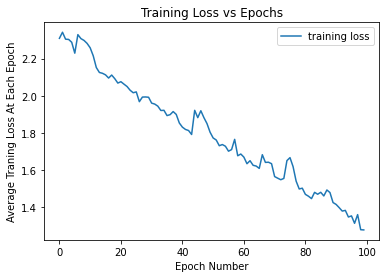

In [ ]:
from torch.nn.utils import weight_norm

class Discriminator(nn.Module):
        """docstring for Discriminator"""
        def __init__(self,num_classes):
            super(Discriminator, self).__init__()
            self.net = nn.Sequential(
                    nn.Dropout(.2),
                    weight_norm(nn.Conv2d(3,96,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(96,96,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(96,96,3,stride=2,padding=1)),
                    nn.LeakyReLU(),

                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(96,192,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(192,192,3,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,1,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,1,stride=1,padding=0)),
                    nn.LeakyReLU(),

                    # nn.AvgPool2d(6,stride=1),
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten()
                )

            self.fc = weight_norm(nn.Linear(192,num_classes))
            
        def forward(self,x):
            inter_layer = self.net(x)
            logits = self.fc(inter_layer)
            return logits
lr = 0.003
num_epochs = 100

model = Discriminator(10)

gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=0.001, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer
    )

epoch: 1  train loss: 1.2240584790706635 train accuracy: 0.512 val accuracy: 0.3195
ETA of completion: 4.583287918567658 minutes
epoch: 2  train loss: 1.2666651904582977 train accuracy: 0.524 val accuracy: 0.3056
ETA of completion: 4.3443568309148155 minutes
epoch: 3  train loss: 1.3113632500171661 train accuracy: 0.562 val accuracy: 0.3222
ETA of completion: 4.2464781681696575 minutes
epoch: 4  train loss: 1.264207899570465 train accuracy: 0.524 val accuracy: 0.3113
ETA of completion: 4.215525054931641 minutes
epoch: 5  train loss: 1.2048846781253815 train accuracy: 0.54 val accuracy: 0.3151
ETA of completion: 4.1968885858853655 minutes
epoch: 6  train loss: 1.203951120376587 train accuracy: 0.552 val accuracy: 0.2939
ETA of completion: 4.105878567695617 minutes
epoch: 7  train loss: 1.1995037496089935 train accuracy: 0.602 val accuracy: 0.3401
ETA of completion: 4.050429248809815 minutes
epoch: 8  train loss: 1.1622832715511322 train accuracy: 0.558 val accuracy: 0.3053
ETA of comple

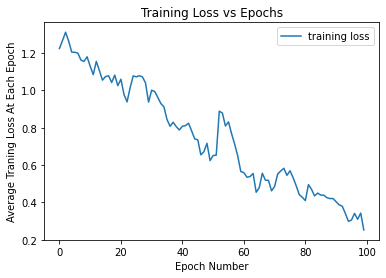

In [ ]:
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer
    )

VAE

In [ ]:
import torch.nn.functional as F
class Classifier(nn.Module):
    """
    A 2-layer convolutional NN with dropout and batch-normalization 
    Dimension progression: 
        (if raw resolution = 96). 96*96*3 -> 96*96*10 -> 48*48*10 -> 48*48*20 -> 12*12*20 -> 64 -> 10 
    """
    def __init__(self, image_reso, filter_size, dropout_rate):
        super(Classifier, self).__init__()
        
        assert filter_size % 2 == 1, "filter_size = %r but it has to be an odd number" % filter_size
        
        # 3 input channels, 10 output channels, 5 x 5 filter size
        self.conv1_drop = nn.Dropout2d(dropout_rate)
        self.conv1 = nn.Conv2d(3, 10, kernel_size=filter_size, stride = 1, padding = (filter_size - 1)//2)  
        self.bn1 = nn.BatchNorm2d(num_features=10)
        
        # reduce spatial dimension by 2 times
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding = 0)   
        
        # 10 input channels, 20 output channels, 5 x 5 filter size
        self.conv2_drop = nn.Dropout2d(dropout_rate)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=filter_size, stride = 1, padding = (filter_size - 1)//2)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        
        # reduce spatial dimension by 4 times 
        self.avgpool = nn.AvgPool2d(kernel_size=4)  
        
        self.fc1 = nn.Linear(20 * (image_reso//8) * (image_reso//8), 64)
        self.fc2 = nn.Linear(64, 100)        

    def forward(self, x):
        
        
        # 3 x 96 x 96 -> 10 x 96 x 96 
        x = self.conv1_drop(x)
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        
        
        # 10 x 96 x 96 -> 10 x 48 x 48
        x = self.pool1(x)
        
        
        # 10 x 48 x 48 -> 20 x 48 x 48
        x = self.conv2_drop(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)     
        
        
        # 20 x 48 x 48 -> 20 x 12 x 12
        x = self.avgpool(x)
               
        # resize the 2d representation to a vector
        x = x.view(-1, 20 * 12 * 12)
    
        # 1 x (20 * 12 * 12) -> 1 x 64 
        x = F.relu(self.fc1(x))

        # 1 x 64 -> 1 x 10 
        x = self.fc2(x)
        
        return x

In [ ]:
mean = [0.49139968, 0.48215827 ,0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]

transform_labeled = transforms.Compose([                   
    transforms.RandomHorizontalFlip(),
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

transform_test = transforms.Compose([
    transforms.Resize(96),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

In [ ]:
root = './tmp'
#adjust this for labeled and unlabed split
labeled_per_class = 50

base_dataset = datasets.CIFAR10(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR10SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)

test_dataset = datasets.CIFAR10(
    root, train=False, transform=transform_test, download=False)

batch_size = 128
l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

Files already downloaded and verified


epoch: 1  train loss: 6.7342846393585205 train accuracy: 0.148 val accuracy: 0.1187
ETA of completion: 4.660430653889974 minutes
epoch: 2  train loss: 5.854830026626587 train accuracy: 0.118 val accuracy: 0.1007
ETA of completion: 4.496020126342773 minutes
epoch: 3  train loss: 3.5002800822257996 train accuracy: 0.168 val accuracy: 0.1684
ETA of completion: 4.451871470610301 minutes
epoch: 4  train loss: 2.8272746801376343 train accuracy: 0.178 val accuracy: 0.173
ETA of completion: 4.2456156492233275 minutes
epoch: 5  train loss: 2.6281777024269104 train accuracy: 0.176 val accuracy: 0.1648
ETA of completion: 4.2224074602127075 minutes
epoch: 6  train loss: 2.513467490673065 train accuracy: 0.198 val accuracy: 0.1789
ETA of completion: 4.124405717849731 minutes
epoch: 7  train loss: 2.308953106403351 train accuracy: 0.236 val accuracy: 0.2153
ETA of completion: 4.049676259358724 minutes
epoch: 8  train loss: 2.237692713737488 train accuracy: 0.222 val accuracy: 0.1897
ETA of completio

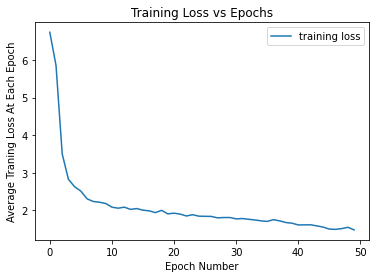

In [ ]:
lr = 0.01
num_epochs = 50

model = Classifier(image_reso = 96, filter_size = 5, dropout_rate = 0.2)

gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    num_epochs,
    criterion,
    optimizer
    )

epoch: 1  train loss: 1.471565067768097 train accuracy: 0.606 val accuracy: 0.2998
ETA of completion: 4.567362713813782 minutes
epoch: 2  train loss: 1.474980652332306 train accuracy: 0.586 val accuracy: 0.2968
ETA of completion: 4.467877960205078 minutes
epoch: 3  train loss: 1.4179272055625916 train accuracy: 0.598 val accuracy: 0.2936
ETA of completion: 4.366035640239716 minutes
epoch: 4  train loss: 1.4431224167346954 train accuracy: 0.62 val accuracy: 0.3122
ETA of completion: 4.772148243586222 minutes
epoch: 5  train loss: 1.4129699170589447 train accuracy: 0.614 val accuracy: 0.3131
ETA of completion: 4.192092061042786 minutes
epoch: 6  train loss: 1.4773008227348328 train accuracy: 0.572 val accuracy: 0.2852
ETA of completion: 4.140837383270264 minutes
epoch: 7  train loss: 1.4186542630195618 train accuracy: 0.624 val accuracy: 0.2989
ETA of completion: 4.008348572254181 minutes
epoch: 8  train loss: 1.4612780809402466 train accuracy: 0.594 val accuracy: 0.2926
ETA of completio

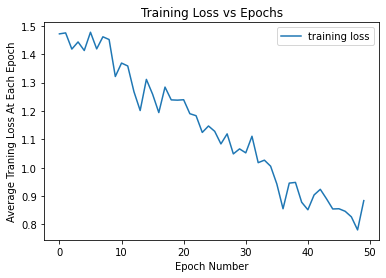

In [ ]:
train_model(
    model,
    l_train_dataloader,
    test_dataloader,
    lr,
    50,
    criterion,
    optimizer
    )